In [1]:
import numpy as np
from matplotlib import pyplot as plt

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp, freq_of_resonator, lp_by_lf



def neuron_output(neuron, signal_freq, shift_degrees=0, phase_number=20):
    y_events = neuron.out_spikes()
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > ((phase_number-1)/signal_freq) * clk_freq + shift_samples) &
        (y_events < ((phase_number/signal_freq) * clk_freq) + shift_samples)
    ]
    if len(y_events) == 0:
        return y_events
    # y_events -= int(((phase_number-1)/signal_freq) * clk_freq + shift_samples)
    return y_events

def events_to_spikes(events, run_window=0, spikes_arr_size=-1):
    if spikes_arr_size == -1:
        y_spikes = np.zeros(events[-1] + 1)
    else:
        y_spikes = np.zeros(spikes_arr_size)

    y_spikes[events] = 1
    if run_window == 0:
        return y_spikes

    y_spikes_rollsum = np.convolve(y_spikes, np.ones(run_window, dtype=int), 'valid')
    return y_spikes_rollsum

def amplify_spikes(base_spikes, spikes_window, base_min, base_max, amplify):
    base_spikes = events_to_spikes(base_spikes-resonator_input[0], spikes_arr_size=int(clk_freq/freq0)+1)
    result = np.zeros_like(base_spikes)
    result[np.arange(len(base_spikes)) % 2 == 1] = 1
    dc = (base_max + base_min)/2
    for i in range(spikes_window, len(result), spikes_window):
        slice_spikes = base_spikes[i:i+spikes_window]
        if len(slice_spikes) < spikes_window:
            break
        curr_spikes = np.sum(slice_spikes) - dc
        new_spikes = int(curr_spikes * amplify)

        if new_spikes > 0:
            spikes_ts = np.linspace(0, spikes_window, new_spikes).astype(int)//2*2 + i
            result[spikes_ts] = 1
        else:
            spikes_ts = np.linspace(0, spikes_window, abs(new_spikes)).astype(int)//2*2 - 1 + i
            result[spikes_ts] = 0
    result = np.where(result == 1)[0]
    return result

def smooth(arr, size):
    filter = np.exp(-(np.arange(size) - size//2)**2 / (2 * (size/4)**2))
    normalized_filter = filter / np.sum(filter)
    res = np.convolve(arr, normalized_filter, 'same')
    res[:size] = arr[:size]
    res[-size:] = arr[-size:]
    return res

clk_freq = 1536000
freq0 = 116
lf = 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
freq0 = freq_of_resonator(clk_freq, lf, best_lp)

duration = 25 / freq0
x = np.linspace(0, duration, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)
freq0

116.63263005207597

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


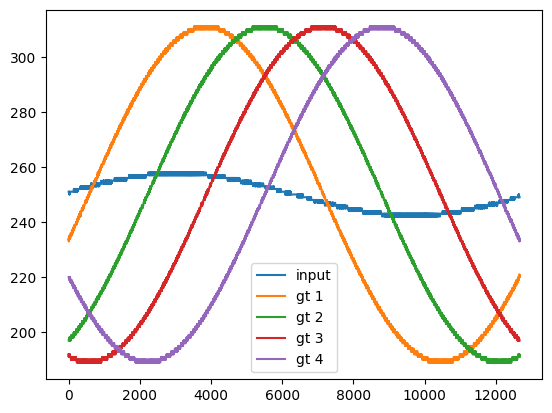

In [2]:
%matplotlib inline

spikes_window = 500
resonator = SpikingNetwork(clk_freq)
resonator.add_amplitude(1000)

# Encode to pdm
neuron = create_SCTN()
neuron.activation_function = IDENTITY
resonator.add_layer(SCTNLayer([neuron]))

wave_length = int(clk_freq/freq0)
resonator.log_out_spikes(-1)
resonator.input_full_data(sine_wave)

resonator_input = neuron_output(resonator.neurons[0], freq0, shift_degrees=0)
rresonator_input = events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1)

ground_truth = []
for phase_shift in [22.5, 67.5, 112.5, 157.5]:
    phase_shift /= 360
    resonator.input_full_data(sine_wave[int((1-phase_shift)*wave_length):int((20-phase_shift)*wave_length)])
    resonator.log_out_spikes(-1)
    resonator.forget_logs()

    resonator.input_full_data(8*sine_wave[int((1-phase_shift)*wave_length):])
    ground_truth.append(neuron_output(resonator.neurons[0], freq0))

gt1 = ground_truth[0]
gt2 = ground_truth[1]
gt3 = ground_truth[2]
gt4 = ground_truth[3]
rolling_gt = []
plt.plot(rresonator_input, label=f'input')
for i, gt in enumerate(ground_truth):
    rolling_gt.append(events_to_spikes(gt-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+1))
    plt.plot(rolling_gt[i], label=f'gt {i+1}')

gt_wave_amplitudes = [(o.max(), o.min()) for o in rolling_gt]

plt.legend()
plt.show()

In [3]:
def learning_resonator(
        lf,
        thetas,
        weights,
        ground_truths,
        A,
        time_to_learn,
        max_weight,
        min_weight,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    tau = network.clk_freq * time_to_learn / 2
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    neuron.set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[0])
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        neuron.set_supervised_stdp(A, tau, clk_freq, max_weight, min_weight, ground_truths[1 + i])
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def simple_resonator(
        freq0,
        clk_freq,
        lf,
        thetas,
        weights,
):
    LF = lf
    LP = lp_by_lf(LF, freq0, clk_freq)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weights[0], -weights[1]], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = thetas[0]
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weights[2+i]], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = thetas[1+i]
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def flat_weights(resonator):
    ws = []
    for neuron in resonator.neurons[1:]:
        for w in neuron.synapses_weights:
            ws.append(abs(float(f'{w:.3f}')))
    return np.array(ws)

def flat_thetas(resonator):
    return [float(f'{neuron.theta:.3f}') for neuron in resonator.neurons[1:]]

def argmax(arr):
    return .5 * (np.argmax(arr) + len(arr) - np.argmax(arr[::-1]) - 1)

## Bias + Weights Learning

In [4]:
# chosen_bias=[-1, -5, -5, -5]
# chosen_weights=[11, 9, 10, 10, 10]

chosen_bias = [-2, -10, -10, -10]
chosen_weights = [27, 23, 20, 20, 20]

In [5]:
resonator = learning_resonator(
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
    ground_truths=ground_truth,
    A=1e-4,
    time_to_learn=1e-5,
    max_weight=np.inf,
    min_weight=-np.inf,
)
learning_rules = [neuron.supervised_stdp for neuron in resonator.neurons[1:]]
for i, neuron in enumerate(resonator.neurons):
    resonator.log_out_spikes(i)
    neuron.supervised_stdp = None

momentum_beta = .01

<IPython.core.display.Javascript object>


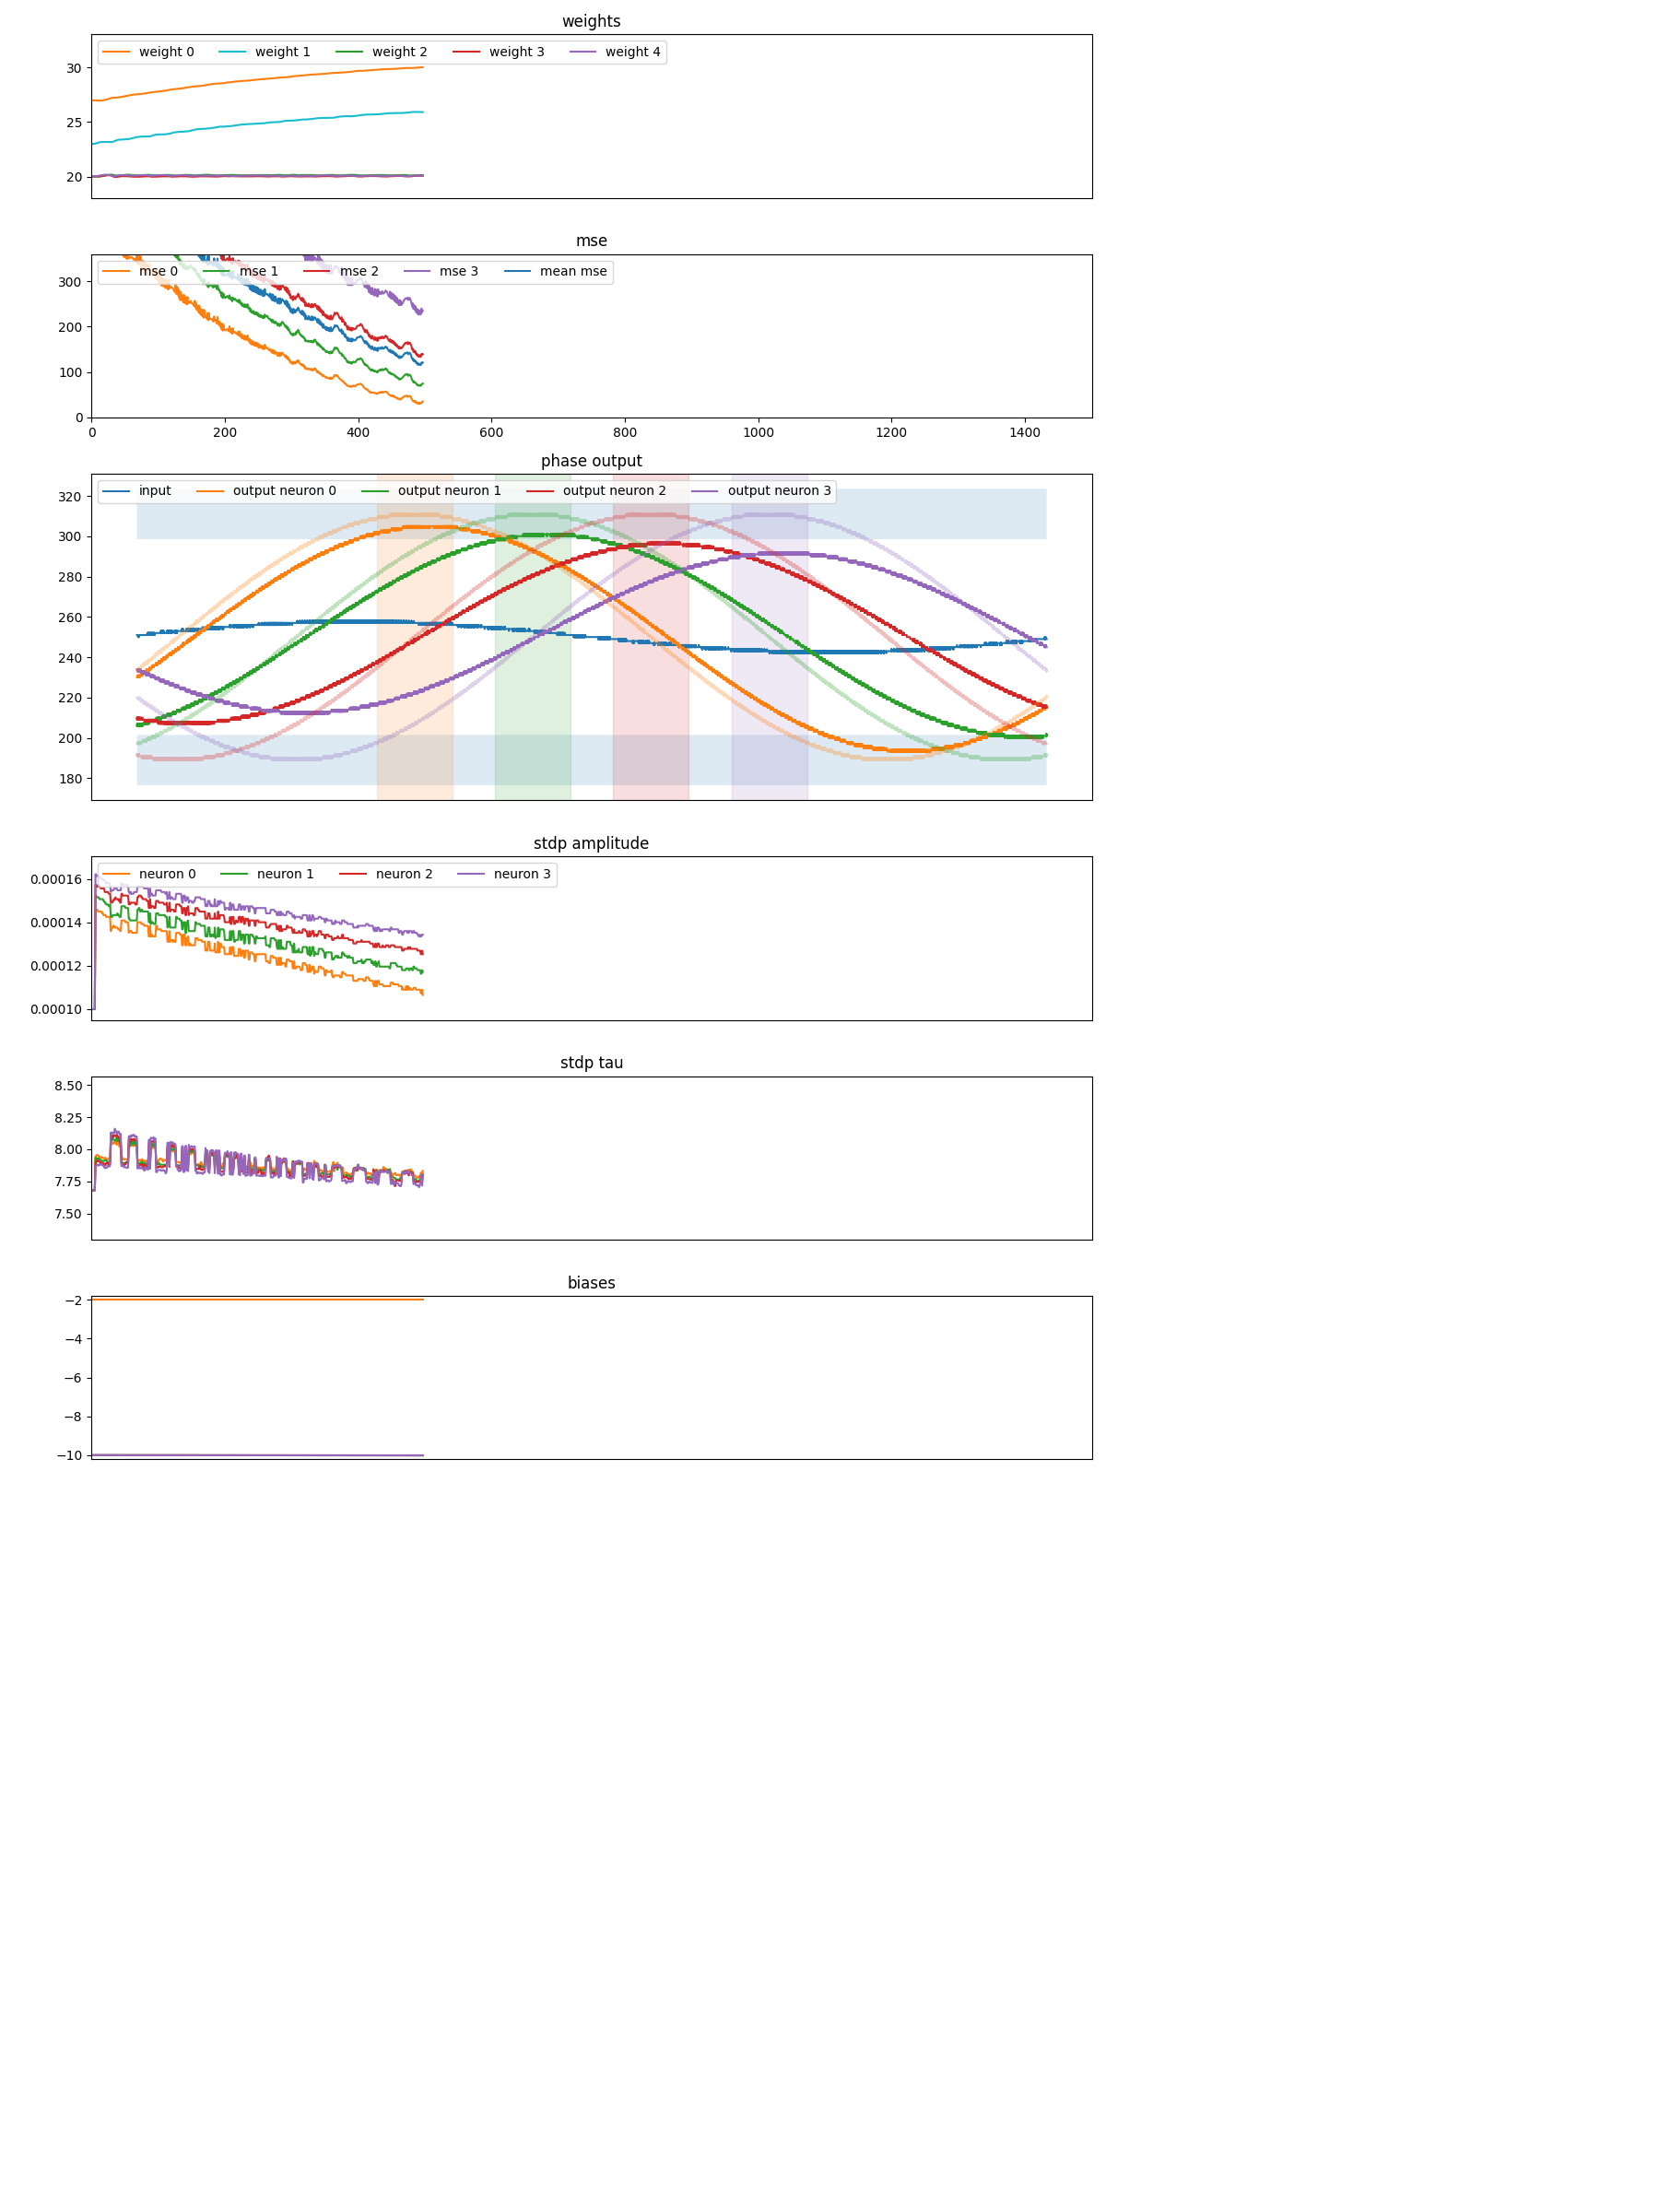

497it [15:47,  1.96s/it, weights=[30.054, 25.925, 20.122, 20.062, 20.05], thetas=[-2.0, -10.015, -10.012, -10.007], mse=123, amplitudes=[(305.0, 193.0), (301.0, 200.0), (297.0, 207.0), (292.0, 212.0)], dc=[250.63144187514797, 253.22413384894642, 253.58219556467523, 252.55283718727804], tuned_parameters=6] 

In [ ]:
%matplotlib notebook
from tqdm import tqdm

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

def_color = '#1f77b4'
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
epochs = 1500

weights = np.zeros((epochs+1, 5))
weights[0, :] = flat_weights(resonator)

biases = np.zeros((epochs+1, 4))
biases[0, :] = flat_thetas(resonator)

mses = np.ones((epochs+1, 5)) * np.inf
mses[0, :4] = np.array([(gt**2).mean() for gt in ground_truth])
mses[0, 4] = mses[0, :4].mean()
min_mse = mses[0, 4]

stdp_amplitude = np.ones((epochs+1, 4)) * np.inf
stdp_amplitude[0, :] = np.array([lr.A for lr in learning_rules])

stdp_tau = np.ones((epochs+1, 4)) * np.inf
stdp_tau[0, :] = np.array([lr.tau for lr in learning_rules])

fig, axs = plt.subplots(6, 1, figsize=(12, 16), gridspec_kw={'height_ratios': [1, 1, 2, 1, 1, 1]})
axs[0].set_title('weights')
axs[0].set_xlim(0, epochs+1)
axs[0].set_xticks([])
weights_lines = [axs[0].plot([w], label=f'weight {i}', color=c)[0] for i, (c, w) in enumerate(zip([colors[0], '#17becf'] + colors[1:], weights[0]))]

y_epsilon = spikes_window * 0.025
x_epsilon = len(rresonator_input) * 15 / 360
# gt_peaks = [.5 * (np.argmax(gt) + len(gt) - np.argmax(gt[::-1]) - 1) for gt in rolling_gt]
gt_peaks = [argmax(gt) for gt in rolling_gt]
x_phase = np.arange(0, len(rresonator_input))
axs[2].set_title('phase output')
axs[2].set_ylim(gt_wave_amplitudes[0][1] - spikes_window * 0.04, gt_wave_amplitudes[0][0] + spikes_window * 0.04)
axs[2].set_xticks([])
axs[2].fill_between(x_phase, gt_wave_amplitudes[0][0] - y_epsilon, gt_wave_amplitudes[0][0] + y_epsilon, facecolor=def_color, alpha=0.15)
axs[2].fill_between(x_phase, gt_wave_amplitudes[0][1] - y_epsilon, gt_wave_amplitudes[0][1] + y_epsilon, facecolor=def_color, alpha=0.15)

axs[2].plot(rresonator_input, label='input', color=def_color)
phase_lines = [axs[2].plot(gt, label=f'output neuron {i}', color=colors[i])[0] for i, gt in enumerate(rolling_gt)]
[axs[2].plot(gt, color=colors[i], alpha=.3)[0] for i, gt in enumerate(rolling_gt)]
[axs[2].axvspan(peak - x_epsilon, peak + x_epsilon, alpha=0.15, color=colors[i]) for i, peak in enumerate(gt_peaks)]

axs[1].set_title('mse')
axs[1].set_xlim(0, epochs+1)
axs[1].set_ylim(0, 10000)
mse_lines = [axs[1].plot([mse], label=f'mse {i}' if i < 4 else 'mean mse', color=color)[0]
             for i, (color, mse) in enumerate(zip(colors + [def_color], mses[0]))]

axs[3].set_title('stdp amplitude')
axs[3].set_xlim(0, epochs+1)
axs[3].set_xticks([])
stdp_ampl_lines = [axs[3].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(stdp_amplitude[0])]

axs[4].set_title('stdp tau')
axs[4].set_xlim(0, epochs+1)
axs[4].set_xticks([])
stdp_tau_lines = [axs[4].plot([w], label=f'neuron {i}', color=colors[i])[0] for i, w in enumerate(stdp_tau[0])]

axs[5].set_title('biases')
axs[5].set_xlim(0, epochs+1)
axs[5].set_xticks([])
biases_lines = [axs[5].plot([w], label=f'bias {i}', color=colors[i])[0] for i, w in enumerate(biases[0])]

fig.tight_layout()

momentum = [0] * 4
max_theta = -0.75
tuned_parameters = 0
all_neurons_on_dc = False
with tqdm() as pbar:
    i = 1
    while tuned_parameters < 8:
        run_with_stdp = True
        tuned_parameters = 0
        for neuron in resonator.neurons:
            neuron.membrane_potential = 0
            neuron.log_rand_gauss_var = 0
        resonator.forget_logs()
        resonator.input_full_data(sine_wave)

        # mse
        output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0],
                                   run_window=spikes_window,
                                   spikes_arr_size=int(clk_freq/freq0)+1)
                  for neuron in resonator.neurons[1:]]
        max_y = 0
        mses[i, :4] = [((gt - o)**2).mean() for gt, o in zip(rolling_gt, output)]
        mses[i, 4] = mses[i, :4].mean()
        if mses[i, 4] < min_mse:
            min_mse = mses[i, 4]
            run_with_stdp = False
        for j, line in enumerate(mse_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(mses[:i, j])
            max_y = np.max([max_y, 1.5*mses[max(0, i-4):i+1, j].max()])
        axs[1].set_ylim(0, max_y)

        # weights chart
        weights[i, :] = flat_weights(resonator)
        for j, line in enumerate(weights_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(weights[:i, j])
        max_y = 1.1*weights[max(0, i-4):i+1, :].max()
        min_y = 0.9*weights[max(0, i-4):i+1, :].min()
        axs[0].set_ylim(min_y, max_y)

        # phase chart
        for j, o in enumerate(output):
            phase_lines[j].set_ydata(o)

        # biases chart
        biases[i, :] = flat_thetas(resonator)
        for j, line in enumerate(biases_lines):
            line.set_xdata(np.arange(i))
            line.set_ydata(biases[:i, j])
        max_y = biases[:i+1, :].max() + 0.2
        min_y = biases[:i+1, :].min() - 0.2
        axs[5].set_ylim(min_y, max_y)

        # stdp charts:
        for j, lr in enumerate(learning_rules):
            stdp_amplitude[i, j] = lr.A
            stdp_ampl_lines[j].set_xdata(np.arange(i))
            stdp_ampl_lines[j].set_ydata(stdp_amplitude[:i, j])
            stdp_tau[i, j] = lr.tau
            stdp_tau_lines[j].set_xdata(np.arange(i))
            stdp_tau_lines[j].set_ydata(stdp_tau[:i, j])
        axs[3].set_ylim(stdp_amplitude[:i, :].min() * .95, stdp_amplitude[:i, :].max() * 1.05)
        axs[4].set_ylim(stdp_tau[:i, :].min() * .95, stdp_tau[:i, :].max() * 1.05)

        thetas_shift = [-.2*(((2*np.mean(o) - spikes_window)/spikes_window)**2)*np.sign(np.mean(o)-spikes_window/2) for o in output]
#         if not all_neurons_on_dc:
        if True:
            all_neurons_on_dc = True
            for j, neuron in enumerate(resonator.neurons[1:]):
                dc = output[j].mean()
#                 if abs(dc - spikes_window/2) < y_epsilon:
#                     continue
                all_neurons_on_dc = False
                bs = thetas_shift[j]
                momentum[j] = bs + momentum_beta * momentum[j]
                neuron.theta += momentum[j]
                if neuron.theta > max_theta:
                    neuron.theta = max_theta

#         if all_neurons_on_dc:
        if True:
            peaks = [argmax(o)for o in output]
            # activate weights learning
            for j, o in enumerate(output):
                dc = o.mean()
                o_max = o.max()
                o_min = o.min()
                neuron = resonator.neurons[1+j]
                # first 2 conditions to check if the amplitude is on the right place.
                # next condition is to check if the peak is in the right place.
                tune_phase = False
                tune_amplitude = False
                o_argmax = argmax(o)
                if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
                    tuned_parameters += 1
#                     if abs(o_argmax - gt_peaks[j]) <= x_epsilon:
#                         tune_phase = True
                if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon and
                    abs(o_min - gt_wave_amplitudes[j][1]) <= y_epsilon
                ):
                    tuned_parameters += 1
#                     if (abs(o_max - gt_wave_amplitudes[j][0]) <= y_epsilon/2 and
#                         abs(o_min - gt_wave_amplitudes[j][1]) <= y_epsilon/2
#                     ):
#                         tune_amplitude = True
                if not run_with_stdp or (tune_phase and tune_amplitude):
                    neuron.supervised_stdp = None
                else:
                    wave_amplitude = o_max - o_min
                    gt_wave_amplitude = gt_wave_amplitudes[j][0] - gt_wave_amplitudes[j][1]
                    wave_amplitude_ratio = abs((wave_amplitude - gt_wave_amplitude)/gt_wave_amplitude)  # number between 0 - 1 represent [0 - gt_wave_amplitude]
                    phase_diff_ratio = abs(peaks[j] - gt_peaks[j]) / len(o)                                   # number between 0 - 1 represent [0 - 180]
                    neuron.supervised_stdp = learning_rules[j]
                    neuron.supervised_stdp.A = (1 + wave_amplitude_ratio) * 10e-5
                    neuron.supervised_stdp.tau = 1 * 1e-5 * clk_freq / 2 * (1 + phase_diff_ratio)

        wave_amplitudes = [(o.max(), o.min()) for o in output]
        pbar.set_postfix({'weights': flat_weights(resonator).tolist(), 'thetas': flat_thetas(resonator), 'mse': mses[i, :].mean(),
                          'amplitudes': wave_amplitudes, 'dc': [o.mean() for o in output], 'tuned_parameters': tuned_parameters})

        for j in range(4):
            axs[j].legend(loc='upper left',  ncol=5 if j < 4 else 4)

        fig.canvas.draw()
        fig.canvas.flush_events()

        pbar.update(1)
        i = (i+1) % epochs

In [199]:
min_mse = i - 1
print(f'min mse {mses[min_mse].mean()}')
chosen_bias = biases[min_mse]
chosen_weights = weights[min_mse]
print(f'chosen_bias={chosen_bias.tolist()}')
print(f'chosen_weights={chosen_weights.tolist()}')

min mse 97.31326067934134
chosen_bias=[-1.0, -5.0, -5.0, -5.0]
chosen_weights=[15.556, 13.496, 9.984, 9.996, 10.018]


In [108]:
chosen_bias=[-2.0, -10.0, -10.0, -10.0]
chosen_weights=[27.875, 24.243, 20.422, 20.055, 20.125]

chosen_bias=[-1.0, -5.0, -5.0, -5.0]
chosen_weights=[11, 9, 10, 10, 10]

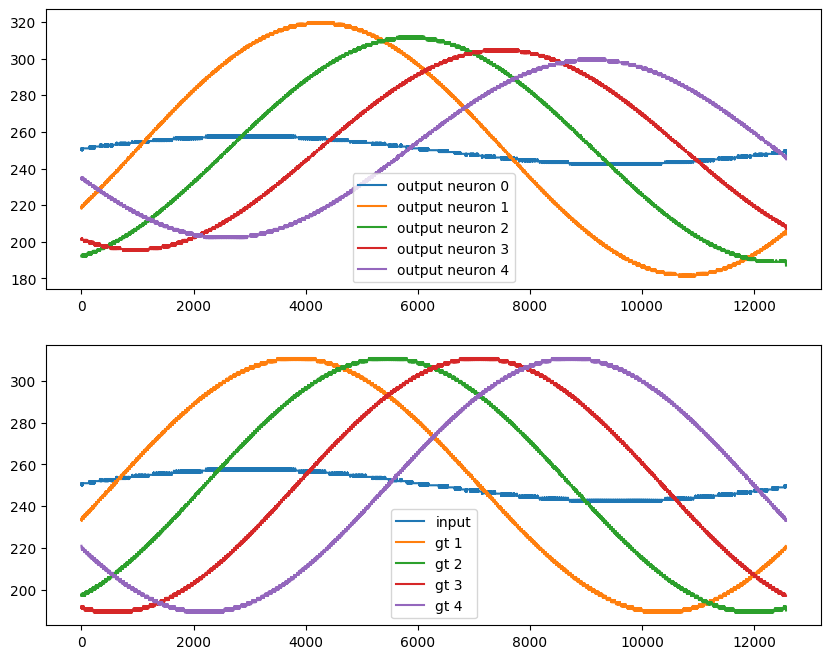

In [200]:
%matplotlib inline
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for i in range(len(res_resonator.neurons)):
    res_resonator.log_out_spikes(i)
res_resonator.input_full_data(sine_wave)

output = [events_to_spikes(neuron_output(neuron, freq0)-resonator_input[0], run_window=spikes_window, spikes_arr_size=int(clk_freq/freq0)+3) for neuron in res_resonator.neurons]
%matplotlib inline

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for i, o in enumerate(output):
    axs[0].plot(o, label=f'output neuron {i}')
axs[0].legend()
axs[1].plot(events_to_spikes(resonator_input-resonator_input[0], run_window=spikes_window), label=f'input')
for i, gt in enumerate(rolling_gt):
    axs[1].plot(gt, label=f'gt {i+1}')

axs[1].legend()

In [115]:
phases = [argmax(o)/len(o) * 360 for o in output]
phases_diffs = [b - a for a, b in zip(phases[:-1], phases[1:])]
phases_diffs

[21.997038290670616, 46.02496297863338, 45.948804738734935, 45.568013539242656]

In [28]:
chosen_bias = [2.5225363755960504*-1, 3.810512069027977*-5, 2.047300870007141*-5, 3.5111111681544327*-5]
chosen_weights = [1.6258641219755*11*1.434, 0.9120013496191507*9, 3.2228003561928453*10, 2.2870158079306058*10, 3.6508438077335685*10]
# chosen_weights = [1.6258641219755*11, 0.9120013496191507*9, 3.2228003561928453*10, 2.2870158079306058*10, 3.6508438077335685*10]

# 117.52980412939964 ~ peak 117.716 nid 1 snr 9.979
# chosen_bias=[-1.0, -5.0, -5.0, -5.0]
# chosen_weights=[15.556, 13.496, 9.984, 9.996, 10.018]


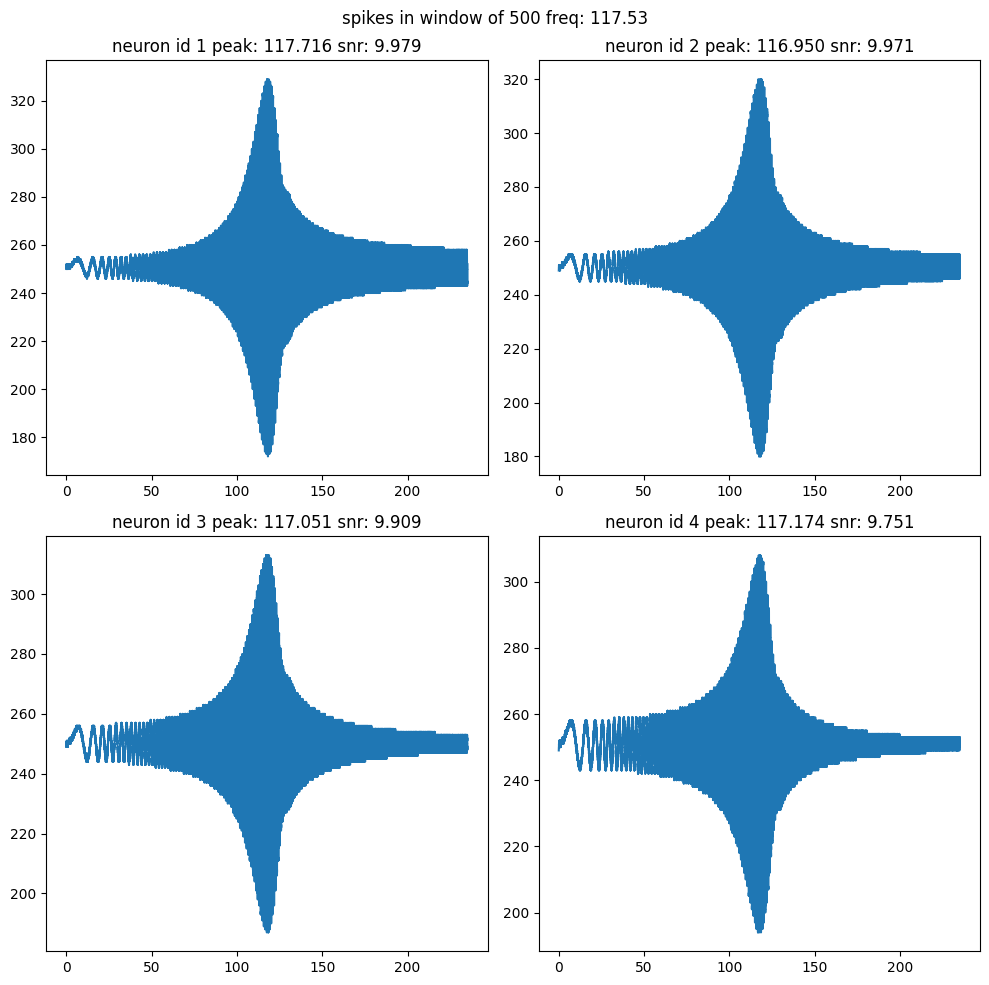

In [201]:
from snn.resonator import test_resonator_on_chirp, freq_of_resonator
res_resonator = simple_resonator(
    clk_freq=clk_freq,
    freq0=freq0,
    lf=lf,
    thetas=chosen_bias,
    weights=chosen_weights,
)

for nid in range(1, 5):
    res_resonator.log_out_spikes(nid)

start_freq = 0
spectrum = 2 * freq0
res_resonator.forget_logs()

step = 100 / clk_freq
test_size = int(spectrum / step)
test_resonator_on_chirp(
    res_resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

snr = [0] * 4
peak = [0] * 4
best_lp = lp_by_lf(lf, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf, best_lp)
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f'spikes in window of {spikes_window} freq: {f_resonator:.2f}')
for nid in range(4):
    spikes_neuron = res_resonator.neurons[nid + 1]
    y_events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(test_size)
    y_spikes[y_events] = 1
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

    ax = axs[nid//2, nid%2]
    # ax.set_ylim(spikes_window/4, 3*spikes_window/4)
    ax.plot(x, y_spikes)
    snr_spikes = y_spikes[3000:]
    snr[nid] = (snr_spikes.max() - snr_spikes.min())/snr_spikes.std()
    peak[nid] = x[3000+np.argmax(snr_spikes)]
    ax.set_title(f'neuron id {nid + 1} peak: {peak[nid]:.3f} snr: {snr[nid]:.3f}')
fig.tight_layout()

nid = np.argmax(np.array(snr) / np.abs(np.array(peak) - freq0))
print(f'# {freq0} ~ peak {peak[nid]:.3f} nid {nid+1} snr {snr[nid]:.3f}')
print(f'# chosen_bias={list(chosen_bias)}')
print(f'# chosen_weights={list(chosen_weights)}')

In [677]:
freq0 = 136

# 104 ~ peak 103.090 nid 1 snr 9.698
# chosen_bias=[-2.599, -6.683, -4.657, -3.765]
# chosen_weights=[13.377, 8.514, 13.424, 9.45, 7.683]

# 119 ~ peak 117.215 nid 2 snr 9.896
# chosen_bias=[-2.592, -6.528, -5.325, -4.282]
# chosen_weights=[16.282, 11.068, 13.172, 10.779, 8.968]

# 136 ~ peak 133.980 nid 3 snr 10.249
# chosen_bias=[-2.213, -6.6, -4.828, -3.93]
# chosen_weights=[26.259, 21.444, 13.145, 9.93, 8.746]

# 142 ~ peak 137.253 nid 2 snr 8.480
# chosen_bias=[-2.498, -6.809, -5.313, -4.121]
# chosen_weights=[25.803, 20.57, 13.554, 10.943, 8.986]

# 155 ~ peak 147.398 nid 1 snr 8.079
# chosen_bias=[-2.594, -7.188, -5.574, -4.256]
# chosen_weights=[28.832, 23.433, 14.541, 11.445, 9.389]

# 173 ~ peak 166.581 nid 3 snr 9.353
# chosen_bias=[-2.972, -8.299, -6.273, -4.645]
# chosen_weights=[34.652, 28.106, 16.717, 12.927, 10.055]

# 195 ~ peak 187.980 nid 2 snr 9.498
# chosen_bias=[-3.568, -9.255, -6.931, -5.014]
# chosen_weights=[42.603, 35.032, 18.317, 14.179, 10.988]

# 212 ~ peak 204.270 nid 1 snr 9.337
# chosen_bias=[-4.237, -10.922, -7.948, -5.61]
# chosen_weights=[41.073, 32.151, 21.887, 16.178, 12.01]

In [ ]:
# 104 ~ peak 106.138 nid 4 snr 11.779
# chosen_bias=[-0.974, -5.187, -5.37, -4.325]
# chosen_weights=[9.69, 7.789, 10.925, 11.655, 9.222]